In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

In [2]:
import xgboost as xgb
from xgboost import plot_importance

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 125)

In [4]:
model_path_name = "all_features_model_fully_tuned"
DIRECTORY_PATH = f"models/{model_path_name}"
MODEL_INFO_FILEPATH = f"{DIRECTORY_PATH}/info.txt"

In [5]:
dataset = pd.read_pickle("datasets/dummy_dataset.pkl")

train_index_stop = 15893 # this is the first index of a new pitcher
val_index_stop = 17898 # make sure no overlapping plays

training_set = dataset.iloc[0:train_index_stop, :]
validation_set = dataset.iloc[train_index_stop:val_index_stop, :]
test_set = dataset.iloc[val_index_stop:,]

train_X = training_set.drop(["GAMEID", "PLAYID", "RUNPASS"],axis=1)
train_y = training_set['RUNPASS']

val_X = validation_set.drop(["GAMEID", "PLAYID", "RUNPASS"],axis=1)
val_y = validation_set['RUNPASS']

test_X = test_set.drop(["GAMEID", "PLAYID", "RUNPASS"],axis=1)
test_y = test_set['RUNPASS']

mapping = {'R' : 0,
           'P': 1
           }
train_y = train_y.map(mapping)
val_y = val_y.map(mapping)
test_y = test_y.map(mapping)

In [6]:
clf = pickle.load(open(f"{DIRECTORY_PATH}/xgb_model.pkl", "rb"))

In [57]:
# https://stackoverflow.com/questions/37340474/xgb-plot-tree-font-size-python
def plot_tree(xgb_model, filename, rankdir='UT', tree_num=0):
    """
    Plot the tree in high resolution
    :param xgb_model: xgboost trained model
    :param filename: the pdf file where this is saved
    :param rankdir: direction of the tree: default Top-Down (UT), accepts:'LR' for left-to-right tree
    :return:
    """
    
    gvz = xgb.to_graphviz(xgb_model, num_trees=tree_num, rankdir=rankdir)
    _, file_extension = os.path.splitext(filename)
    format = file_extension.strip('.').lower()
    data = gvz.pipe(format=format)
    full_filename = filename
    with open(full_filename, 'wb') as f:
        f.write(data)

In [59]:
for tree_number in range(1,6):
    plot_tree(clf, f"{DIRECTORY_PATH}/tree_graph_{tree_number}.pdf", tree_num=tree_number)

In [25]:
dataset.dtypes[0:20]

GAMEID                     int64
PLAYID                     int64
WEEK                       int64
QUARTER                 category
SCOREDIFFERENTIAL          int64
SCORE                    float64
DISTANCE                   int64
DOWN                    category
FIELDPOSITION              int64
DRIVE                    float64
DRIVEPLAY                float64
OFFTIMEOUTSREMAINING    category
DEFTIMEOUTSREMAINING    category
HASH                    category
SPOTLEFT                   int64
2MINUTE                    int64
CLOCK_INT                  int64
prev_FORCEDFUMBLE        float64
prev_HIT                 float64
prev_HURRY               float64
dtype: object

In [31]:
dataset[(dataset.prev_GAINLOSSNET < 5)].RUNPASS.value_counts()

RUNPASS
P    6459
R    2330
Name: count, dtype: int64

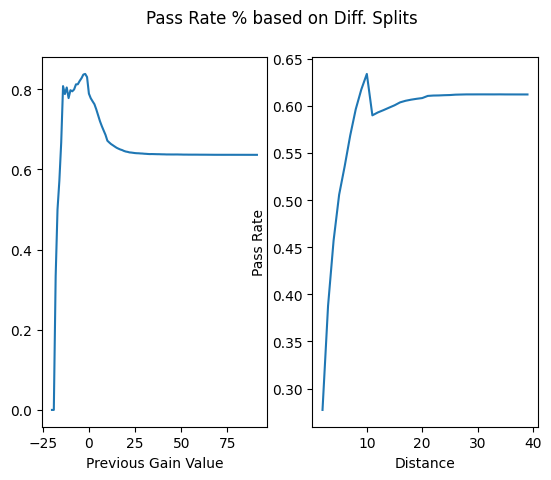

In [46]:
fig, (ax1, ax2) = plt.subplots(1,2)

gain_values = np.sort(dataset.prev_GAINLOSSNET.dropna().unique())
y_gain = [dataset[(dataset.prev_GAINLOSSNET < gain_val)].RUNPASS.map({"P":1, "R":0}).astype(int).mean() for gain_val in gain_values]
ax1.plot(gain_values, y_gain)

distances = np.sort(dataset.DISTANCE.dropna().unique())
y_dist = [dataset[(dataset.DISTANCE < dist)].RUNPASS.map({"P":1, "R":0}).astype(int).mean() for dist in distances]
ax2.plot(distances, y_dist)

fig.suptitle(f"Pass Rate % based on Diff. Splits")
ax1.set_xlabel("Previous Gain Value")
ax2.set_xlabel("Distance")
plt.ylabel("Pass Rate")
plt.savefig("images/tree_analysis/pass_rates_by_splits.png")
plt.show()


In [23]:
dataset[(dataset.prev_GAINLOSSNET >= 5)].RUNPASS.value_counts()

RUNPASS
P    3991
R    3643
Name: count, dtype: int64

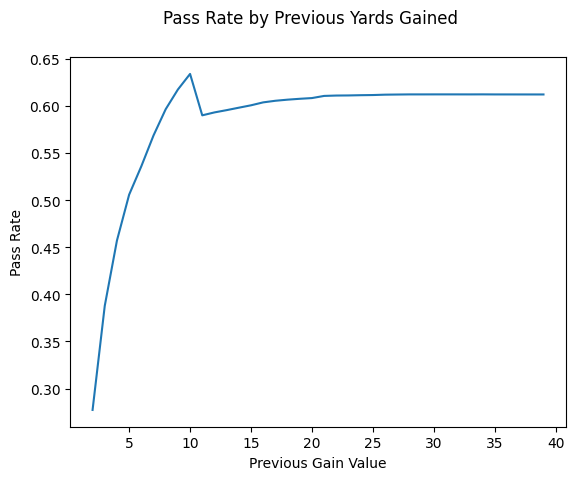

In [39]:
fig, ax = plt.subplots()

distances = np.sort(dataset.DISTANCE.dropna().unique())
y = [dataset[(dataset.DISTANCE < dist)].RUNPASS.map({"P":1, "R":0}).astype(int).mean() for dist in distances]
plt.plot(distances, y)

fig.suptitle("Pass Rate by Distance")
plt.xlabel("Previous Gain Value")
plt.ylabel("Pass Rate")
#plt.savefig("images/tree_analysis/pass_rate_by_prev_yards_gained_line_chart.png")
plt.show()

In [52]:
dataset[(dataset.prev_GAINLOSSNET >= 5) & (dataset.DISTANCE < 2)].RUNPASS.value_counts()

RUNPASS
R    489
P    193
Name: count, dtype: int64

In [50]:
dataset[(dataset.DISTANCE < 2)].RUNPASS.value_counts(normalize=True)

RUNPASS
R    0.722711
P    0.277289
Name: proportion, dtype: float64

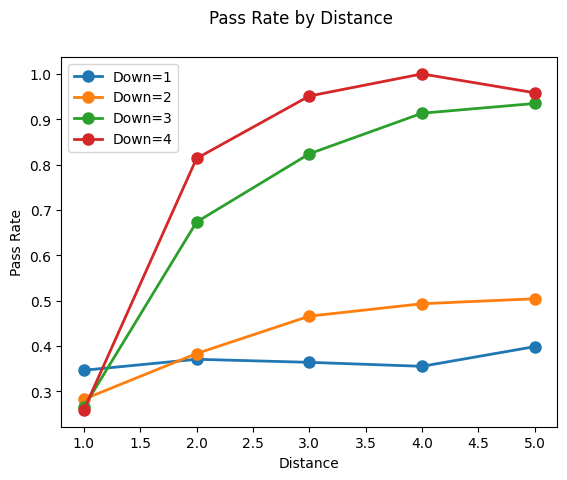

In [56]:
fig, ax = plt.subplots()

downs = dataset.DOWN.unique()
distances = np.sort(dataset.DISTANCE.unique())[0:5]
for down in downs:
    down_df = dataset[dataset.DOWN == down]
    y = [down_df.query("DISTANCE == @dist").RUNPASS.map({"P":1, "R":0}).astype(int).mean() for dist in distances]
    widths = np.array([down_df.query("DISTANCE == @dist").shape[0] for dist in distances])
    # #widths = widths/max(widths)
    ax.plot(distances, y, marker='o', linewidth=2, markersize=8,  label=f"Down={down}")
    
fig.suptitle("Pass Rate by Distance")

plt.legend()
plt.xlabel("Distance")
plt.ylabel("Pass Rate")
plt.savefig("images/tree_analysis/pass_rate_by_distances_to_five.png")
plt.show()

In [26]:
dataset[(dataset.prev_GAINLOSSNET >= 5) & (dataset['2MINUTE'] < 2) & (dataset.DOWN != 3) & (dataset.DISTANCE < 2)].RUNPASS.value_counts()

RUNPASS
R    291
P     95
Name: count, dtype: int64

In [15]:
dataset[(dataset.prev_GAINLOSSNET >= 5) & (dataset['2MINUTE'] < 2) & (dataset.DOWN == 3) & (dataset.DISTANCE < 2)].RUNPASS.value_counts()

RUNPASS
R    149
P     47
Name: count, dtype: int64

In [20]:
train_y[train_X[(train_X.prev_GAINLOSSNET >= 5) & (train_X['2MINUTE'] < 2) & (train_X.DOWN == 3) & (train_X.DISTANCE < 2)].index].value_counts()

RUNPASS
0    127
1     40
Name: count, dtype: int64

In [21]:
test_y[test_X[(test_X.prev_GAINLOSSNET >= 5) & (test_X['2MINUTE'] < 2) & (test_X.DOWN == 3) & (test_X.DISTANCE < 2)].index].value_counts()

RUNPASS
0    8
1    2
Name: count, dtype: int64